## Library

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
from scipy import stats

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Variables (customize these)

In [2]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Peter'                             # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)
initial_gdp = 21 * trillion                       # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)


# Variable sets - definitely change these!
if USE_NUMBERS == 'Ajeya':
    CREDIBLE_INTERVAL = 0.9                        # These are 90% CIs
    tai_flop_size = lognorm(27.58, 46.29)          # 90% CI, it takes 10^FLOPs to run a transformative AI at inference. Take 10^13-17 from Carlsmith report and add 1 OOM due to algorithmic inefficiency.
                                                   # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day, or a total of about 10^20 operations
    algo_doubling_rate = norm(2.5, 2.5)            # 90% CI, algorithms get twice as efficient every X years
    min_reduction = norm(2, 2)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(5, 5)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17.2, 17.2)    # 90% CI, as of today, we can buy 10^X FLOPs per $
    flops_halving_rate = norm(2.6, 3)              # 90% CI, the cost of FLOPs per $ halves every X years
    max_flops_per_dollar = norm(24, 24)            # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    initial_pay = norm(8.7, 8.7)                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    gdp_growth = norm(1.03, 1.03)                  # 90% CI, GDP will increase by a factor of X each year
    max_gdp_frac = norm(0.01, 0.01)                # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    willingness_ramp = norm(1, 1)                  # 90% CI, if we are X% of the spend needed to acheive TAI, we will instantly jump to TAI
    spend_doubling_time = norm(2.5, 2.5)           # 90% CI, our willingness to spend on TAI doubles every X years
    initial_chance_of_nonscaling_issue = 0         # What is the chance there will be a non-scaling issue if TAI is feasible in `CURRENT_YEAR`?
    final_chance_of_nonscaling_issue = 0           # What is the chance there will be a non-scaling issue if TAI is feasible only by `nonscaling_issue_bottom_year` (see below)?
    nonscaling_issue_bottom_year = 0               # What year will will the chance of a non-scaling issue bottom out at (reaching `final_chance_of_nonscaling_issue`)?
    nonscaling_delay = norm(0, 0)                  # 90% CI, conditional on a delay, how many additional years will TAI be delayed due to issues unrelated to scaling to an adequate number of FLOPs (e.g., collecting the relevant training data)?
    base_p_recursive = 0                           # TODO: explain
    recursive_curve_steepness = 0
    recursive_curve_inflection = 0
    p_recursive_creates_tai_instantly = 0
    recursive_flops_halving_rate_ = None
    recursive_algo_doubling_rate_ = None
    recursive_spend_doubling_time = None
    recursive_gdp_growth_ = None
    recursive_initial_chance_of_nonscaling_issue = None
    recursive_final_chance_of_nonscaling_issue = None

elif USE_NUMBERS == 'Peter':
    CREDIBLE_INTERVAL = 0.9
    tai_flop_size = lognorm(26, 46)
    algo_doubling_rate = norm_lclip(1, 5)
    min_reduction = norm(1, 3)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(4, 8)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17, 17.5)      # More increase in compute, plus possibilities that big companies have found some additional initial efficiency.
    flops_halving_rate = norm(2, 4)
    max_flops_per_dollar = norm(22, 27)            # Added uncertainty around fundamental limits
    initial_pay = norm(7, 8)                       # Minimum of $10M since that has already happened. Uncertain of how much we could be paying privately.
    gdp_growth = norm(1.015, 1.03)                 # Added uncertainty around potential GDP slowdown
    max_gdp_frac = lognorm_lclip(0.0015, 0.025)    # Added uncertainty around how much of GDP we'd be willing to spend
    willingness_ramp = norm(0.7, 1)
    spend_doubling_time = lognorm_lclip(0.5, 2)    # Added uncertainty around how fast spending will accelerate
    initial_chance_of_nonscaling_issue = 0.9
    final_chance_of_nonscaling_issue = 0.1
    nonscaling_issue_bottom_year = 2060
    nonscaling_delay = lognorm(1, 20)
    base_p_recursive = 0.5
    recursive_curve_steepness = 35
    recursive_curve_inflection = 0.1
    p_recursive_creates_tai_instantly = 0.05
    recursive_flops_halving_rate = lognorm_lclip(0.3, 2)
    recursive_algo_doubling_rate = lognorm_lclip(0.3, 2)
    recursive_spend_doubling_time = lognorm_lclip(0.3, 2)
    recursive_gdp_growth = lognorm_lclip(1.02, 1.1)
    recursive_initial_chance_of_nonscaling_issue = 0.2
    recursive_final_chance_of_nonscaling_issue = 0.01
    
else:
    raise ValueError


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)

def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 709:
        return 10 ** (math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)

def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)

def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def p_nonscaling_delay(initial_p, final_p, year, max_year):
    initial_p = initial_p - final_p
    p_ = initial_p - (initial_p * ((year - CURRENT_YEAR) / (max_year - CURRENT_YEAR))) + final_p
    return final_p if p_ < final_p else p_

def p_rapid_recursive_self_improvement(flops_needed_for_tai, flops_we_have, base_p, curve_steepness, curve_inflection):
    if flops_we_have > 10 ** 250:
        return base_p  # Handle overflow error
    else:
        ratio = flops_we_have / flops_needed_for_tai
        return base_p / (1 + math.exp(-curve_steepness * (ratio - curve_inflection)))

    
# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')


Loaded


In [3]:
initial_flops_p = get_percentiles([sample(tai_flop_size, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
initial_flops_p

{95: 25.871370933888333,
 90: 27.89235852994194,
 80: 30.03058239807123,
 70: 31.61871521035656,
 60: 32.92151207059711,
 50: 34.40485233693306,
 40: 36.23121303616972,
 30: 37.92589241166026,
 20: 39.82513138354079,
 10: 42.52836701351539,
 5: 45.69004123981296}

In [4]:
min_reduction_p = get_percentiles([sample(min_reduction, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
min_reduction_p

{95: 0.9623109471920064,
 90: 1.2130471438868493,
 80: 1.5244810811900031,
 70: 1.7037733213626063,
 60: 1.8805137892689583,
 50: 2.043492762506967,
 40: 2.196456541954944,
 30: 2.3522992868147856,
 20: 2.5337500752025686,
 10: 2.782933665442251,
 5: 3.0248397064436543}

In [5]:
max_reduction_p = get_percentiles([sample(max_reduction, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
max_reduction_p

{95: 4.0059831299009545,
 90: 4.4631313535286,
 80: 5.022145425127173,
 70: 5.4238175485004865,
 60: 5.735194382155387,
 50: 6.029730240200147,
 40: 6.306186191813161,
 30: 6.660122303334878,
 20: 7.085054061814653,
 10: 7.634310409742636,
 5: 8.082332411245513}

In [6]:
algo_doubling_rate_p = get_percentiles([sample(algo_doubling_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
algo_doubling_rate_p

{95: 1.0,
 90: 1.4291193203971833,
 80: 1.993106583174743,
 70: 2.3121349347979265,
 60: 2.612439877034372,
 50: 2.985925368688492,
 40: 3.2817933791465945,
 30: 3.576279167540858,
 20: 3.938668721426109,
 10: 4.5363322570064675,
 5: 4.885902136004082}

In [7]:
initial_flops_per_dollar_p = get_percentiles([sample(initial_flops_per_dollar, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
initial_flops_per_dollar_p

{5: 17.016883828088435,
 10: 17.082607321921294,
 20: 17.137432342639876,
 30: 17.185163998547655,
 40: 17.22014827968469,
 50: 17.25406738633737,
 60: 17.284252635875593,
 70: 17.322473261124557,
 80: 17.366339224893217,
 90: 17.42815174792101,
 95: 17.4761398623044}

In [8]:
flops_halving_rate_p = get_percentiles([sample(flops_halving_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
flops_halving_rate_p

{95: 2.033445591340797,
 90: 2.2301848516650575,
 80: 2.4735456321482467,
 70: 2.6853702396835866,
 60: 2.8387767197602285,
 50: 2.9856998190651627,
 40: 3.162936947166378,
 30: 3.3305148461904572,
 20: 3.5171499463972475,
 10: 3.8204601184235982,
 5: 4.038900144909809}

In [9]:
max_flops_per_dollar_p = get_percentiles([sample(max_flops_per_dollar, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
max_flops_per_dollar_p

{5: 22.022073700645652,
 10: 22.64090494494633,
 20: 23.269610222124275,
 30: 23.70785822267021,
 40: 24.12158361068565,
 50: 24.623054644378826,
 60: 24.987232067836267,
 70: 25.33229781358542,
 80: 25.762189789500468,
 90: 26.439699346800055,
 95: 26.957410794640968}

In [10]:
initial_pay_p = get_percentiles([sample(initial_pay, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
initial_pay_p

{5: 6.999401737074015,
 10: 7.111992811383033,
 20: 7.236043547268285,
 30: 7.334322070954645,
 40: 7.418036535007261,
 50: 7.495569264126038,
 60: 7.573159854275425,
 70: 7.644214072761872,
 80: 7.742834673405087,
 90: 7.874423364551926,
 95: 7.995260783467819}

In [11]:
gdp_growth_p = get_percentiles([sample(gdp_growth, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
gdp_growth_p

{5: 1.0151726870647368,
 10: 1.0167884268225826,
 20: 1.0189363239380291,
 30: 1.0205095718360189,
 40: 1.0217364584405249,
 50: 1.0228585965186539,
 60: 1.0238700753764565,
 70: 1.025098093708861,
 80: 1.0264323294545161,
 90: 1.0280712705797699,
 95: 1.0298965044763402}

In [12]:
max_gdp_frac_p = get_percentiles([sample(max_gdp_frac, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
max_gdp_frac_p

{5: 0.0015759554272640267,
 10: 0.0020639499007053994,
 20: 0.0029498753614214074,
 30: 0.0038834456685581478,
 40: 0.005043548422755359,
 50: 0.00621143628837992,
 60: 0.0075402616093318406,
 70: 0.009528785137272584,
 80: 0.012830297227566163,
 90: 0.018985297856839806,
 95: 0.0246067243389697}

In [13]:
willingness_ramp_p = get_percentiles([sample(willingness_ramp, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
willingness_ramp_p

{5: 0.7122045274557307,
 10: 0.7424894807502384,
 20: 0.7875079941332608,
 30: 0.8123018008168733,
 40: 0.8316304414058442,
 50: 0.8528649808965527,
 60: 0.872632362824709,
 70: 0.8994630500282454,
 80: 0.925124210459453,
 90: 0.9605836657771097,
 95: 0.9925734726725307}

In [14]:
spend_doubling_time_p = get_percentiles([sample(spend_doubling_time, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
spend_doubling_time_p

{95: 0.5140684416520506,
 90: 0.5889421469849738,
 80: 0.7234171223129819,
 70: 0.8121688216846822,
 60: 0.9188507231550403,
 50: 1.0157763696469622,
 40: 1.136941828710649,
 30: 1.283977742298332,
 20: 1.4687036807723093,
 10: 1.7320318516332398,
 5: 2.1013575682683108}

In [15]:
nonscaling_delay_p = get_percentiles([sample(nonscaling_delay, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
nonscaling_delay_p

{95: 0.9592351114975268,
 90: 1.4041010493349184,
 80: 2.073975379006694,
 70: 2.7690281289878693,
 60: 3.505255299754044,
 50: 4.483684830016692,
 40: 5.5392462381328595,
 30: 7.0575371749098235,
 20: 9.291762475066834,
 10: 14.196381478832643,
 5: 19.237879954038}

In [16]:
if recursive_flops_halving_rate:
    recursive_flops_halving_rate_ = get_percentiles([sample(recursive_flops_halving_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_flops_halving_rate_)
else:
    print('N/A')


{5: 0.3209399751995109, 10: 0.3762591378019528, 20: 0.49024987922027996, 30: 0.5984949965384978, 40: 0.6812135407809475, 50: 0.772528802677503, 60: 0.8844486638219176, 70: 1.0508425762426234, 80: 1.2823894267970155, 90: 1.6225332509179915, 95: 1.9374121847124832}


In [17]:
if recursive_algo_doubling_rate:
    recursive_algo_doubling_rate_ = get_percentiles([sample(recursive_algo_doubling_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_algo_doubling_rate_)
else:
    print('N/A')
    

{5: 0.3096157002177455, 10: 0.3880000789185589, 20: 0.4997032618401438, 30: 0.6124835149102582, 40: 0.7059519644281079, 50: 0.809554929858088, 60: 0.9406079853086203, 70: 1.0899789872900472, 80: 1.2845047775176845, 90: 1.5715037621147492, 95: 1.9636292293131703}


In [18]:
if recursive_spend_doubling_time:
    recursive_spend_doubling_time_ = get_percentiles([sample(recursive_spend_doubling_time, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_spend_doubling_time_)
else:
    print('N/A')


{5: 0.3, 10: 0.3669360514096099, 20: 0.4659410624889565, 30: 0.5568259345933184, 40: 0.6564151508395133, 50: 0.7618929920193696, 60: 0.8898301925928314, 70: 1.0193267045264371, 80: 1.2341840714450598, 90: 1.6203367439694294, 95: 1.8856653745940706}


In [19]:
if recursive_gdp_growth:
    recursive_gdp_growth_ = get_percentiles([sample(recursive_gdp_growth, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_gdp_growth_)
else:
    print('N/A')
    

{5: 1.0221615811991225, 10: 1.0292174637998452, 20: 1.040383649637799, 30: 1.0472946522152426, 40: 1.0536698437959344, 50: 1.059383247519171, 60: 1.0666454314242517, 70: 1.0733101250724153, 80: 1.082451039056674, 90: 1.0927930507721442, 95: 1.1004686487587148}


## GDP Over Time

Text(0, 0.5, 'log GDP')

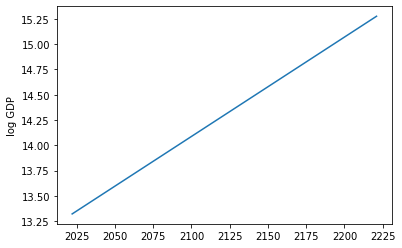

In [20]:
gdp_ = np.array([gdp(initial_gdp=initial_gdp,
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [21]:
for y in years:
    print('Year: {} - GDP log$ {} ({})'.format(y,
                                               np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                               numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log$ 13.3 (10 trillion)
Year: 2023 - GDP log$ 13.3 (10 trillion)
Year: 2024 - GDP log$ 13.3 (10 trillion)
Year: 2025 - GDP log$ 13.4 (10 trillion)
Year: 2026 - GDP log$ 13.4 (10 trillion)
Year: 2027 - GDP log$ 13.4 (10 trillion)
Year: 2028 - GDP log$ 13.4 (10 trillion)
Year: 2029 - GDP log$ 13.4 (10 trillion)
Year: 2030 - GDP log$ 13.4 (10 trillion)
Year: 2031 - GDP log$ 13.4 (10 trillion)
Year: 2032 - GDP log$ 13.4 (10 trillion)
Year: 2033 - GDP log$ 13.4 (10 trillion)
Year: 2034 - GDP log$ 13.4 (10 trillion)
Year: 2035 - GDP log$ 13.4 (10 trillion)
Year: 2036 - GDP log$ 13.5 (10 trillion)
Year: 2037 - GDP log$ 13.5 (10 trillion)
Year: 2038 - GDP log$ 13.5 (10 trillion)
Year: 2039 - GDP log$ 13.5 (10 trillion)
Year: 2040 - GDP log$ 13.5 (10 trillion)
Year: 2041 - GDP log$ 13.5 (10 trillion)
Year: 2042 - GDP log$ 13.5 (10 trillion)
Year: 2043 - GDP log$ 13.5 (10 trillion)
Year: 2044 - GDP log$ 13.5 (10 trillion)
Year: 2045 - GDP log$ 13.5 (10 trillion)
Year: 2046 - GDP

## Willingness to Pay Over Time

Text(0, 0.5, 'log $ willing to spend on TAI')

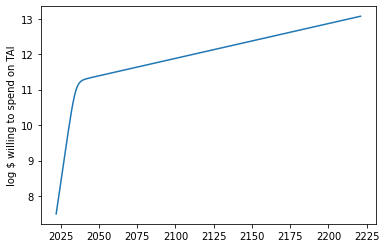

In [22]:
willingness = np.array([willingness_to_pay(initial_gdp=initial_gdp,
                                           gdp_growth=gdp_growth_p[GRAPH_P],
                                           initial_pay=10 ** initial_pay_p[GRAPH_P],
                                           spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                           max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                           year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(willingness))
plt.ylabel('log $ willing to spend on TAI')


In [23]:
for y in years:
    print('Year: {} - willingness log$ {} ({})'.format(y,
                                                       np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(willingness[y - CURRENT_YEAR]))))

Year: 2022 - willingness log$ 7.5 (10 million)
Year: 2023 - willingness log$ 7.8 (10 million)
Year: 2024 - willingness log$ 8.1 (100 million)
Year: 2025 - willingness log$ 8.4 (100 million)
Year: 2026 - willingness log$ 8.7 (100 million)
Year: 2027 - willingness log$ 9.0 (100 million)
Year: 2028 - willingness log$ 9.3 (one billion)
Year: 2029 - willingness log$ 9.6 (one billion)
Year: 2030 - willingness log$ 9.8 (one billion)
Year: 2031 - willingness log$ 10.1 (10 billion)
Year: 2032 - willingness log$ 10.4 (10 billion)
Year: 2033 - willingness log$ 10.6 (10 billion)
Year: 2034 - willingness log$ 10.8 (10 billion)
Year: 2035 - willingness log$ 11.0 (10 billion)
Year: 2036 - willingness log$ 11.1 (100 billion)
Year: 2037 - willingness log$ 11.2 (100 billion)
Year: 2038 - willingness log$ 11.2 (100 billion)
Year: 2039 - willingness log$ 11.3 (100 billion)
Year: 2040 - willingness log$ 11.3 (100 billion)
Year: 2041 - willingness log$ 11.3 (100 billion)
Year: 2042 - willingness log$ 11.3 (

## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

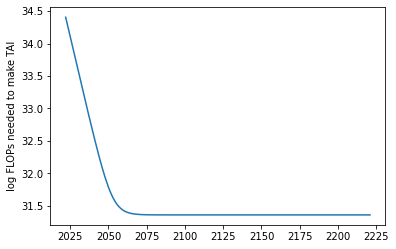

In [24]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [25]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} ({})'.format(y,
                                                               np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                               numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 34.4 (10 decillion)
Year: 2023 - log FLOPs needed for TAI 34.3 (10 decillion)
Year: 2024 - log FLOPs needed for TAI 34.2 (10 decillion)
Year: 2025 - log FLOPs needed for TAI 34.1 (10 decillion)
Year: 2026 - log FLOPs needed for TAI 34.0 (10 decillion)
Year: 2027 - log FLOPs needed for TAI 33.9 (one decillion)
Year: 2028 - log FLOPs needed for TAI 33.8 (one decillion)
Year: 2029 - log FLOPs needed for TAI 33.7 (one decillion)
Year: 2030 - log FLOPs needed for TAI 33.6 (one decillion)
Year: 2031 - log FLOPs needed for TAI 33.5 (one decillion)
Year: 2032 - log FLOPs needed for TAI 33.4 (one decillion)
Year: 2033 - log FLOPs needed for TAI 33.3 (one decillion)
Year: 2034 - log FLOPs needed for TAI 33.2 (one decillion)
Year: 2035 - log FLOPs needed for TAI 33.1 (one decillion)
Year: 2036 - log FLOPs needed for TAI 33.0 (one decillion)
Year: 2037 - log FLOPs needed for TAI 32.9 (100 nonillion)
Year: 2038 - log FLOPs needed for TAI 32.8 (100 nonillion)
Ye

## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

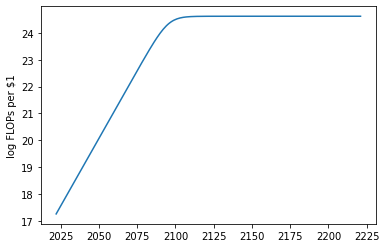

In [26]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [27]:
for y in years:
    print('Year: {} - log {} FLOPs per $ ({})'.format(y,
                                                      np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                      numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 17.3 FLOPs per $ (100 quadrillion)
Year: 2023 - log 17.4 FLOPs per $ (100 quadrillion)
Year: 2024 - log 17.5 FLOPs per $ (100 quadrillion)
Year: 2025 - log 17.6 FLOPs per $ (100 quadrillion)
Year: 2026 - log 17.7 FLOPs per $ (100 quadrillion)
Year: 2027 - log 17.8 FLOPs per $ (100 quadrillion)
Year: 2028 - log 17.9 FLOPs per $ (100 quadrillion)
Year: 2029 - log 18.0 FLOPs per $ (100 quadrillion)
Year: 2030 - log 18.1 FLOPs per $ (one quintillion)
Year: 2031 - log 18.2 FLOPs per $ (one quintillion)
Year: 2032 - log 18.3 FLOPs per $ (one quintillion)
Year: 2033 - log 18.4 FLOPs per $ (one quintillion)
Year: 2034 - log 18.5 FLOPs per $ (one quintillion)
Year: 2035 - log 18.6 FLOPs per $ (one quintillion)
Year: 2036 - log 18.7 FLOPs per $ (one quintillion)
Year: 2037 - log 18.8 FLOPs per $ (one quintillion)
Year: 2038 - log 18.9 FLOPs per $ (one quintillion)
Year: 2039 - log 19.0 FLOPs per $ (one quintillion)
Year: 2040 - log 19.1 FLOPs per $ (10 quintillion)
Year: 2041 - 

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

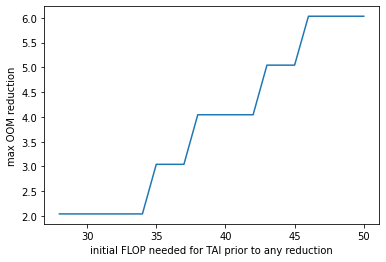

In [28]:
tai_sizes = range(28, 51)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')

In [29]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                            max_reduction_p[GRAPH_P],
                                                                                            t)))
          

TAI log FLOP 28 -> 2.043492762506967 OOM reductions possible
TAI log FLOP 29 -> 2.043492762506967 OOM reductions possible
TAI log FLOP 30 -> 2.043492762506967 OOM reductions possible
TAI log FLOP 31 -> 2.043492762506967 OOM reductions possible
TAI log FLOP 32 -> 2.043492762506967 OOM reductions possible
TAI log FLOP 33 -> 2.043492762506967 OOM reductions possible
TAI log FLOP 34 -> 2.043492762506967 OOM reductions possible
TAI log FLOP 35 -> 3.043492762506967 OOM reductions possible
TAI log FLOP 36 -> 3.043492762506967 OOM reductions possible
TAI log FLOP 37 -> 3.043492762506967 OOM reductions possible
TAI log FLOP 38 -> 4.0434927625069665 OOM reductions possible
TAI log FLOP 39 -> 4.0434927625069665 OOM reductions possible
TAI log FLOP 40 -> 4.0434927625069665 OOM reductions possible
TAI log FLOP 41 -> 4.0434927625069665 OOM reductions possible
TAI log FLOP 42 -> 4.0434927625069665 OOM reductions possible
TAI log FLOP 43 -> 5.0434927625069665 OOM reductions possible
TAI log FLOP 44 ->

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

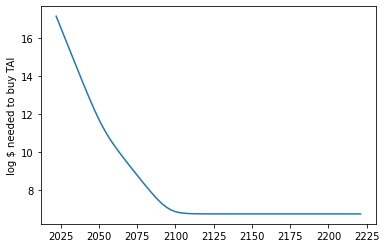

In [30]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [31]:
for y in years:
    print('Year: {} - log $ {} to buy TAI ({})'.format(y,
                                                       np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 17.2 to buy TAI (100 quadrillion)
Year: 2023 - log $ 16.9 to buy TAI (10 quadrillion)
Year: 2024 - log $ 16.7 to buy TAI (10 quadrillion)
Year: 2025 - log $ 16.5 to buy TAI (10 quadrillion)
Year: 2026 - log $ 16.3 to buy TAI (10 quadrillion)
Year: 2027 - log $ 16.1 to buy TAI (10 quadrillion)
Year: 2028 - log $ 15.9 to buy TAI (one quadrillion)
Year: 2029 - log $ 15.7 to buy TAI (one quadrillion)
Year: 2030 - log $ 15.5 to buy TAI (one quadrillion)
Year: 2031 - log $ 15.3 to buy TAI (one quadrillion)
Year: 2032 - log $ 15.1 to buy TAI (one quadrillion)
Year: 2033 - log $ 14.9 to buy TAI (100 trillion)
Year: 2034 - log $ 14.7 to buy TAI (100 trillion)
Year: 2035 - log $ 14.5 to buy TAI (100 trillion)
Year: 2036 - log $ 14.3 to buy TAI (100 trillion)
Year: 2037 - log $ 14.1 to buy TAI (100 trillion)
Year: 2038 - log $ 13.9 to buy TAI (10 trillion)
Year: 2039 - log $ 13.7 to buy TAI (10 trillion)
Year: 2040 - log $ 13.5 to buy TAI (10 trillion)
Year: 2041 - log $ 13.4 t

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

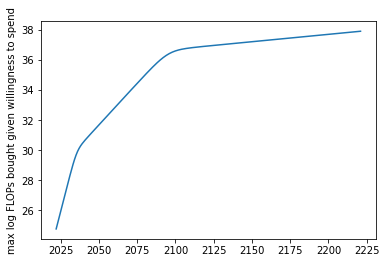

In [32]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=initial_gdp,
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [33]:
for y in years:
    print('Year: {} - max log FLOPs {} ({})'.format(y,
                                                    np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                    numerize(np.log10(flops_at_max_[y - CURRENT_YEAR]))))

Year: 2022 - max log FLOPs 24.7 (one septillion)
Year: 2023 - max log FLOPs 25.1 (10 septillion)
Year: 2024 - max log FLOPs 25.5 (10 septillion)
Year: 2025 - max log FLOPs 25.9 (10 septillion)
Year: 2026 - max log FLOPs 26.3 (100 septillion)
Year: 2027 - max log FLOPs 26.7 (100 septillion)
Year: 2028 - max log FLOPs 27.1 (one octillion)
Year: 2029 - max log FLOPs 27.5 (one octillion)
Year: 2030 - max log FLOPs 27.9 (one octillion)
Year: 2031 - max log FLOPs 28.3 (10 octillion)
Year: 2032 - max log FLOPs 28.7 (10 octillion)
Year: 2033 - max log FLOPs 29.0 (100 octillion)
Year: 2034 - max log FLOPs 29.4 (100 octillion)
Year: 2035 - max log FLOPs 29.7 (100 octillion)
Year: 2036 - max log FLOPs 29.9 (100 octillion)
Year: 2037 - max log FLOPs 30.1 (one nonillion)
Year: 2038 - max log FLOPs 30.3 (one nonillion)
Year: 2039 - max log FLOPs 30.4 (one nonillion)
Year: 2040 - max log FLOPs 30.5 (one nonillion)
Year: 2041 - max log FLOPs 30.7 (one nonillion)
Year: 2042 - max log FLOPs 30.8 (one no

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

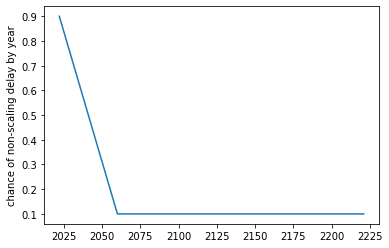

In [34]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                   final_chance_of_nonscaling_issue,
                                                   year=y,
                                                   max_year=nonscaling_issue_bottom_year) for y in years])

plt.plot(years, p_nonscaling_delay_)
plt.ylabel('chance of non-scaling delay by year')
# TODO: Make logistic?

In [35]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 90.0%
Year: 2023 - p(nonscaling delay) = 87.9%
Year: 2024 - p(nonscaling delay) = 85.8%
Year: 2025 - p(nonscaling delay) = 83.7%
Year: 2026 - p(nonscaling delay) = 81.6%
Year: 2027 - p(nonscaling delay) = 79.5%
Year: 2028 - p(nonscaling delay) = 77.4%
Year: 2029 - p(nonscaling delay) = 75.3%
Year: 2030 - p(nonscaling delay) = 73.2%
Year: 2031 - p(nonscaling delay) = 71.1%
Year: 2032 - p(nonscaling delay) = 68.9%
Year: 2033 - p(nonscaling delay) = 66.8%
Year: 2034 - p(nonscaling delay) = 64.7%
Year: 2035 - p(nonscaling delay) = 62.6%
Year: 2036 - p(nonscaling delay) = 60.5%
Year: 2037 - p(nonscaling delay) = 58.4%
Year: 2038 - p(nonscaling delay) = 56.3%
Year: 2039 - p(nonscaling delay) = 54.2%
Year: 2040 - p(nonscaling delay) = 52.1%
Year: 2041 - p(nonscaling delay) = 50.0%
Year: 2042 - p(nonscaling delay) = 47.9%
Year: 2043 - p(nonscaling delay) = 45.8%
Year: 2044 - p(nonscaling delay) = 43.7%
Year: 2045 - p(nonscaling delay) = 41.6%
Year: 2046 - p(n

## Chance of Rapid Recursive Self-Improvement

Text(0.5, 0, 'percentage of TAI-level FLOP')

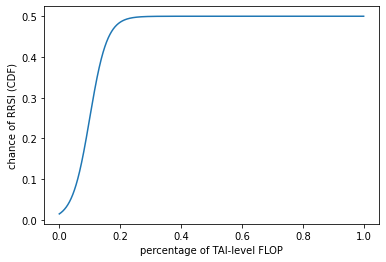

In [36]:
p_rrsi_ = np.array([p_rapid_recursive_self_improvement(10000,
                                                       x,
                                                       base_p_recursive,
                                                       recursive_curve_steepness,
                                                       recursive_curve_inflection) for x in range(10000)])

plt.plot([r / 10000 for r in range(10000)], p_rrsi_)
plt.ylabel('chance of RRSI (CDF)')
plt.xlabel('percentage of TAI-level FLOP')

In [37]:
samples = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
           1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for i in samples:
    print('Ratio: {} in 10000 - p(RRSI) (CDF) = {}%'.format(i, np.round(p_rrsi_[i-1] * 100, 1)))

Ratio: 1 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 5 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 10 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 20 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 30 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 40 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 50 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 60 in 10000 - p(RRSI) (CDF) = 1.8%
Ratio: 70 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 80 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 90 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 100 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 200 in 10000 - p(RRSI) (CDF) = 2.9%
Ratio: 300 in 10000 - p(RRSI) (CDF) = 4.0%
Ratio: 400 in 10000 - p(RRSI) (CDF) = 5.4%
Ratio: 500 in 10000 - p(RRSI) (CDF) = 7.4%
Ratio: 600 in 10000 - p(RRSI) (CDF) = 9.9%
Ratio: 700 in 10000 - p(RRSI) (CDF) = 12.9%
Ratio: 800 in 10000 - p(RRSI) (CDF) = 16.6%
Ratio: 900 in 10000 - p(RRSI) (CDF) = 20.6%
Ratio: 1000 in 10000 - p(RRSI) (CDF) = 25.0%
Ratio: 1100 in 10000 - p(RRSI) (CDF) = 29.3%
Ratio: 1200 in 10000 - p(RRSI) (CDF) = 33.4%
Ratio: 1300 in 

## Run Model

Running
## RUN 1/10000 ##
Diagnostic: tai_flop_size=31.712907981883895, nonscaling_delay=0.623290020854982, algo_doubling_rate=2.8289203923859016, possible_algo_reduction=2.0542477399014447, initial_flops_per_dollar=1.698957614674777e+17, flops_halving_rate=3.284040969022727, max_flops_per_dollar=3.631028340748443e+24, initial_pay=29590063.37564971, gdp_growth=1.0300442082350842, max_gdp_frac=0.013774210438123475, willingness_ramp=0.883327810832262, spend_doubling_time=0.9615157222705715
-
It takes 31.7 log FLOPs (10 nonillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 24.6 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.0x per year to a max of 0.0138% of GDP. GDP grows at a rate of 1.03x per year.
If we are 88.0% of the way to paying for TAI, we wil

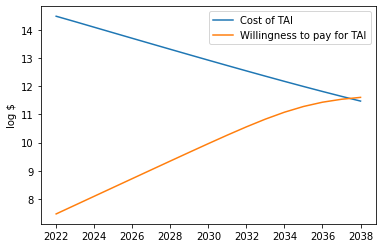

## RUN 2/10000 ##
Diagnostic: tai_flop_size=31.520162489521024, nonscaling_delay=8.830365769109628, algo_doubling_rate=1.9372185694066328, possible_algo_reduction=1.437981919008545, initial_flops_per_dollar=2.4503509692758262e+17, flops_halving_rate=3.6444084969620327, max_flops_per_dollar=3.1690976382626354e+23, initial_pay=24918457.320978794, gdp_growth=1.0222255840636651, max_gdp_frac=0.006880591929761839, willingness_ramp=0.8432690249914141, spend_doubling_time=1.5716346987533465
-
It takes 31.5 log FLOPs (10 nonillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 1.4 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 23.5 log FLOPs (100 sextillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.6x per year to a max of 0.0069% of GDP. GDP grows at a rate of 1.022x per year.
If we are 84.0% of the way to paying for TAI, we will r

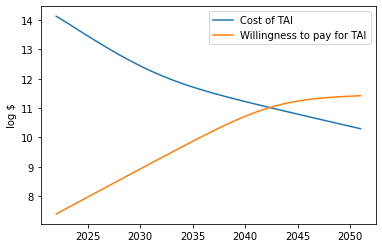

## RUN 3/10000 ##
Diagnostic: tai_flop_size=28.961081207092192, nonscaling_delay=22.527420170784804, algo_doubling_rate=2.4148538889035835, possible_algo_reduction=2.181193049803531, initial_flops_per_dollar=1.758683603147316e+17, flops_halving_rate=3.728182075758731, max_flops_per_dollar=5.336863631963887e+23, initial_pay=17622071.20550595, gdp_growth=1.0160497747495942, max_gdp_frac=0.012298396382588788, willingness_ramp=0.8168839966632736, spend_doubling_time=0.6867103097730682
-
It takes 29.0 log FLOPs (10 octillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.7 years they get 2x cheaper, to a maximum of 23.7 log FLOPs (100 sextillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 0.7x per year to a max of 0.0123% of GDP. GDP grows at a rate of 1.016x per year.
If we are 82.0% of the way to paying for TAI, we will ramp

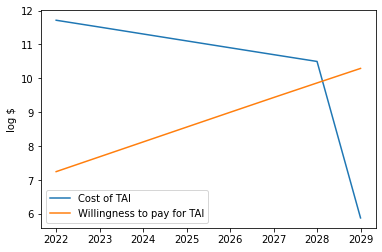

## RUN 4/10000 ##
Diagnostic: tai_flop_size=25.914677476142142, nonscaling_delay=1.748089683150195, algo_doubling_rate=2.6227685163761936, possible_algo_reduction=1.6672354842518873, initial_flops_per_dollar=1.836879069959863e+17, flops_halving_rate=3.8441685810183532, max_flops_per_dollar=7.671349542585067e+26, initial_pay=24887734.96158292, gdp_growth=1.015499009143572, max_gdp_frac=0.003188942708271983, willingness_ramp=0.7191623005542824, spend_doubling_time=1.152727749720847
-
It takes 25.9 log FLOPs (10 septillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.8 years they get 2x cheaper, to a maximum of 26.9 log FLOPs (100 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.2x per year to a max of 0.0032% of GDP. GDP grows at a rate of 1.015x per year.
If we are 72.0% of the way to paying for TAI, we will ramp

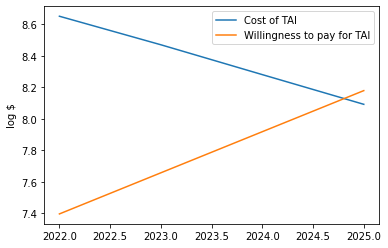

## RUN 5/10000 ##
Diagnostic: tai_flop_size=39.40528099146967, nonscaling_delay=5.174130435125453, algo_doubling_rate=2.9421266442431246, possible_algo_reduction=3.990282938332265, initial_flops_per_dollar=1.7083151242371037e+17, flops_halving_rate=3.59307292714412, max_flops_per_dollar=9.629501528491914e+24, initial_pay=45680937.911665924, gdp_growth=1.0368521711131913, max_gdp_frac=0.02590256009198209, willingness_ramp=0.775893805728856, spend_doubling_time=0.7090855920799327
-
It takes 39.4 log FLOPs (one million decillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 4.0 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 25.0 log FLOPs (one septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.7x per year to a max of 0.0259% of GDP. GDP grows at a rate of 1.037x per year.
If we are 78.0% of the way to paying for TAI, we wil

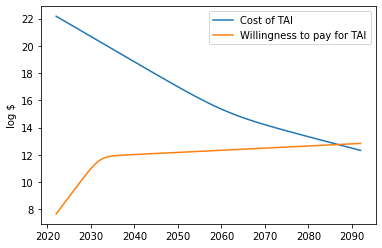

## RUN 6/10000 ##
Diagnostic: tai_flop_size=35.510157631524045, nonscaling_delay=4.114134843632639, algo_doubling_rate=3.2138198083922282, possible_algo_reduction=2.6779231044193814, initial_flops_per_dollar=1.0277612573687408e+17, flops_halving_rate=2.4731727717754755, max_flops_per_dollar=1.4657897125856008e+24, initial_pay=32649110.218538735, gdp_growth=1.0186776968941567, max_gdp_frac=0.016601961801256074, willingness_ramp=0.7567447466954793, spend_doubling_time=0.5
-
It takes 35.5 log FLOPs (100 decillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (100 quadrillion) per $. Every 2.5 years they get 2x cheaper, to a maximum of 24.2 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.5x per year to a max of 0.0166% of GDP. GDP grows at a rate of 1.019x per year.
If we are 76.0% of the way to paying for TAI, we will ramp to paying

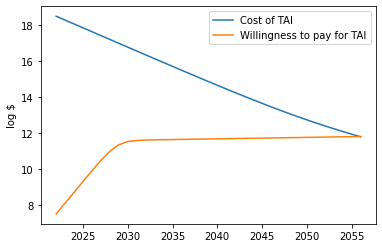

## RUN 7/10000 ##
Diagnostic: tai_flop_size=34.89284924960426, nonscaling_delay=14.346926908070476, algo_doubling_rate=4.837338168017359, possible_algo_reduction=2.673866459368191, initial_flops_per_dollar=1.0885646446514493e+17, flops_halving_rate=3.0592365400500827, max_flops_per_dollar=1.5745604630364517e+25, initial_pay=32244867.87969047, gdp_growth=1.0190775861119532, max_gdp_frac=0.0025350418315652685, willingness_ramp=0.8261507633737672, spend_doubling_time=0.7779562578021434
-
It takes 34.9 log FLOPs (10 decillion) for transformative capabilities.
Every 4.8 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (100 quadrillion) per $. Every 3.1 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.8x per year to a max of 0.0025% of GDP. GDP grows at a rate of 1.019x per year.
If we are 83.0% of the way to paying for TAI, we will ram

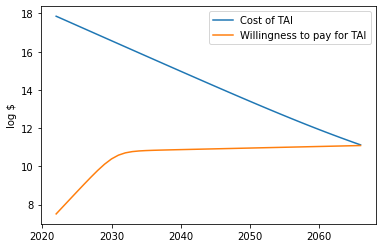

## RUN 8/10000 ##
Diagnostic: tai_flop_size=27.219345422773365, nonscaling_delay=1.4121579930375894, algo_doubling_rate=1, possible_algo_reduction=1.0453021927287862, initial_flops_per_dollar=1.565452560466951e+17, flops_halving_rate=2.0160446830745498, max_flops_per_dollar=1.2628664390880681e+24, initial_pay=57539420.69530747, gdp_growth=1.0215332373636548, max_gdp_frac=0.011962300280934705, willingness_ramp=0.892489034243595, spend_doubling_time=1.0809218281614321
-
It takes 27.2 log FLOPs (one octillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 1.0 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.0 years they get 2x cheaper, to a maximum of 24.1 log FLOPs (one septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.1x per year to a max of 0.012% of GDP. GDP grows at a rate of 1.022x per year.
If we are 89.0% of the way to paying for TAI, we will ramp to paying for TA

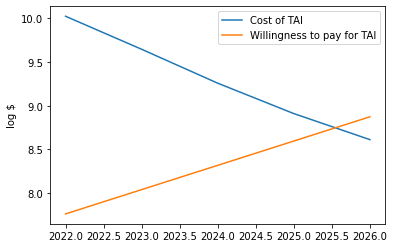

## RUN 9/10000 ##
Diagnostic: tai_flop_size=30.306989500484836, nonscaling_delay=14.496817440416814, algo_doubling_rate=2.3063461097442275, possible_algo_reduction=2.167194481680006, initial_flops_per_dollar=1.7431659772110982e+17, flops_halving_rate=2.9800065717290085, max_flops_per_dollar=1.291228063599498e+24, initial_pay=11591211.357021015, gdp_growth=1.0231969165778305, max_gdp_frac=0.0031308732629564432, willingness_ramp=0.9652176826761909, spend_doubling_time=0.6002129929806318
-
It takes 30.3 log FLOPs (one nonillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 24.1 log FLOPs (one septillion) per $.
We are willing to pay 7.1 log $ (10 million) and this increases by 0.6x per year to a max of 0.0031% of GDP. GDP grows at a rate of 1.023x per year.
If we are 97.0% of the way to paying for TAI, we will

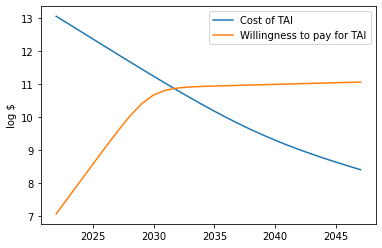

## RUN 10/10000 ##
Diagnostic: tai_flop_size=44.12407619134478, nonscaling_delay=6.856838936875558, algo_doubling_rate=2.3314325077336293, possible_algo_reduction=4.811699873758308, initial_flops_per_dollar=1.8691232298969658e+17, flops_halving_rate=3.0481535469104917, max_flops_per_dollar=1.1649996287608197e+22, initial_pay=46480721.72588112, gdp_growth=1.0241674187119003, max_gdp_frac=0.0027654405842193657, willingness_ramp=0.8172958109376672, spend_doubling_time=1.2259191692858498
-
It takes 44.1 log FLOPs (100 billion decillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 4.8 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 22.1 log FLOPs (10 sextillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 1.2x per year to a max of 0.0028% of GDP. GDP grows at a rate of 1.024x per year.
If we are 82.0% of the way to paying for TAI, w

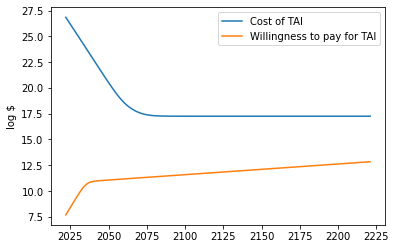

## RUN 11/10000 ##
Diagnostic: tai_flop_size=36.30952749660649, nonscaling_delay=1.4477461295510188, algo_doubling_rate=2.1979386638348135, possible_algo_reduction=3.5842855713349513, initial_flops_per_dollar=1.6023476265810093e+17, flops_halving_rate=1.9015013495710393, max_flops_per_dollar=2.6751809663364596e+20, initial_pay=61426179.58615556, gdp_growth=1.0164556163481417, max_gdp_frac=0.015070629537099528, willingness_ramp=0.8938147724918363, spend_doubling_time=0.6898426650907616
-
It takes 36.3 log FLOPs (one thousand decillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 3.6 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 1.9 years they get 2x cheaper, to a maximum of 20.4 log FLOPs (100 quintillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 0.7x per year to a max of 0.0151% of GDP. GDP grows at a rate of 1.016x per year.
If we are 89.0% of the way to paying for TA

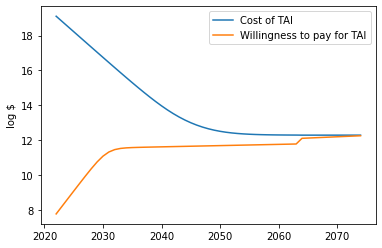

## RUN 12/10000 ##
Diagnostic: tai_flop_size=37.270266277809775, nonscaling_delay=4.29696134608328, algo_doubling_rate=2.4027128365474844, possible_algo_reduction=3.5336960793259458, initial_flops_per_dollar=1.4560972290206275e+17, flops_halving_rate=2.401896878175495, max_flops_per_dollar=2.79247858894006e+21, initial_pay=29501777.432096694, gdp_growth=1.0216478259347814, max_gdp_frac=0.005130474101741686, willingness_ramp=1.003867158787854, spend_doubling_time=0.9321254349424347
-
It takes 37.3 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.4 years they get 2x cheaper, to a maximum of 21.4 log FLOPs (one sextillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.9x per year to a max of 0.0051% of GDP. GDP grows at a rate of 1.022x per year.
If we are 100.0% of the way to paying for TAI, we

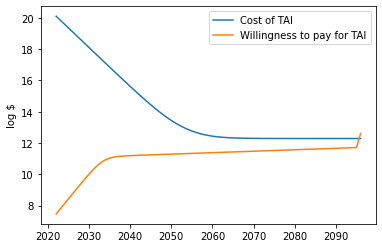

## RUN 13/10000 ##
Diagnostic: tai_flop_size=32.75654129319984, nonscaling_delay=1.1974380596402237, algo_doubling_rate=4.75084726880174, possible_algo_reduction=1.5979398225084986, initial_flops_per_dollar=1.9349663301815347e+17, flops_halving_rate=3.3190511604589665, max_flops_per_dollar=2.331473443225036e+27, initial_pay=28193508.801302966, gdp_growth=1.0259584441448626, max_gdp_frac=0.003348212009278941, willingness_ramp=0.9361920682195398, spend_doubling_time=0.5
-
It takes 32.8 log FLOPs (100 nonillion) for transformative capabilities.
Every 4.8 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 27.4 log FLOPs (one octillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.5x per year to a max of 0.0033% of GDP. GDP grows at a rate of 1.026x per year.
If we are 94.0% of the way to paying for TAI, we will ramp to paying fo

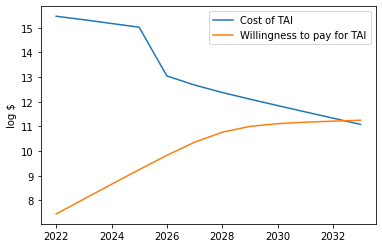

## RUN 14/10000 ##
Diagnostic: tai_flop_size=27.52544090318425, nonscaling_delay=1.3782276202974881, algo_doubling_rate=3.1212104426538603, possible_algo_reduction=0.0611724193807881, initial_flops_per_dollar=2.082053794323736e+17, flops_halving_rate=3.3159914334439433, max_flops_per_dollar=7.049814213929346e+26, initial_pay=6144333.113263275, gdp_growth=1.024307651073442, max_gdp_frac=0.003644364701108541, willingness_ramp=0.7509534020333286, spend_doubling_time=0.5
-
It takes 27.5 log FLOPs (one octillion) for transformative capabilities.
Every 3.1 years algorithms get 2x better, with 0.1 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 26.8 log FLOPs (100 septillion) per $.
We are willing to pay 6.8 log $ (one million) and this increases by 0.5x per year to a max of 0.0036% of GDP. GDP grows at a rate of 1.024x per year.
If we are 75.0% of the way to paying for TAI, we will ramp to paying f

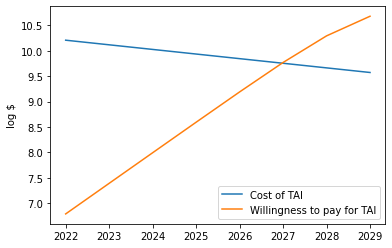

## RUN 15/10000 ##
Diagnostic: tai_flop_size=32.565774888988905, nonscaling_delay=2.8699549225001992, algo_doubling_rate=3.5428838249298233, possible_algo_reduction=1.667143502065053, initial_flops_per_dollar=8.997040534157118e+16, flops_halving_rate=3.88939074460625, max_flops_per_dollar=7.010436494472438e+25, initial_pay=17220240.87985847, gdp_growth=1.0227656465421702, max_gdp_frac=0.012661748348499929, willingness_ramp=0.7126786793267421, spend_doubling_time=0.5
-
It takes 32.6 log FLOPs (100 nonillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (10 quadrillion) per $. Every 3.9 years they get 2x cheaper, to a maximum of 25.8 log FLOPs (10 septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 0.5x per year to a max of 0.0127% of GDP. GDP grows at a rate of 1.023x per year.
If we are 71.0% of the way to paying for TAI, we will ramp to paying for T

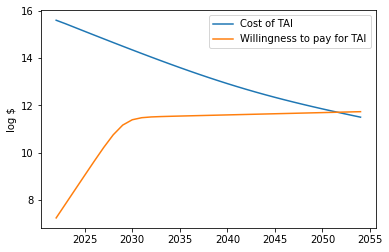

## RUN 16/10000 ##
Diagnostic: tai_flop_size=38.528215684247186, nonscaling_delay=0.5514144717817514, algo_doubling_rate=2.069521579072976, possible_algo_reduction=4.08424642234068, initial_flops_per_dollar=1.9489993448414224e+17, flops_halving_rate=2.862905841150237, max_flops_per_dollar=5.494295244531758e+23, initial_pay=16851606.33167746, gdp_growth=1.018591394825818, max_gdp_frac=0.003558281614109493, willingness_ramp=0.8190579338328844, spend_doubling_time=0.9074233412971652
-
It takes 38.5 log FLOPs (100 thousand decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 23.7 log FLOPs (100 sextillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 0.9x per year to a max of 0.0036% of GDP. GDP grows at a rate of 1.019x per year.
If we are 82.0% of the way to paying for TAI, we 

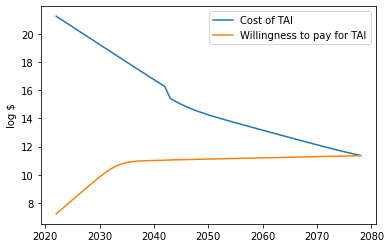

## RUN 17/10000 ##
Diagnostic: tai_flop_size=26.694420350074648, nonscaling_delay=6.784051232017856, algo_doubling_rate=2.8764848490905357, possible_algo_reduction=2.2842280419671486, initial_flops_per_dollar=2.1152474416814074e+17, flops_halving_rate=2.1567982629826368, max_flops_per_dollar=1.3926380291678398e+26, initial_pay=10693324.257356936, gdp_growth=1.0258301293732532, max_gdp_frac=0.0063936197513329756, willingness_ramp=0.9746445013445426, spend_doubling_time=0.906256847775802
-
It takes 26.7 log FLOPs (100 septillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.2 years they get 2x cheaper, to a maximum of 26.1 log FLOPs (100 septillion) per $.
We are willing to pay 7.0 log $ (10 million) and this increases by 0.9x per year to a max of 0.0064% of GDP. GDP grows at a rate of 1.026x per year.
If we are 97.0% of the way to paying for TAI, we wi

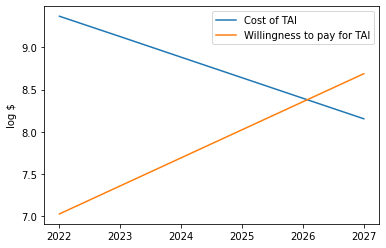

## RUN 18/10000 ##
Diagnostic: tai_flop_size=24.00345640931307, nonscaling_delay=2.3763790968726513, algo_doubling_rate=1, possible_algo_reduction=1.2939805869473213, initial_flops_per_dollar=2.4780492493551942e+17, flops_halving_rate=2.430553526985096, max_flops_per_dollar=1.1970056168334272e+24, initial_pay=21517872.732759323, gdp_growth=1.0212041850834455, max_gdp_frac=0.0017294848214337054, willingness_ramp=0.6937311783327005, spend_doubling_time=1.8448454524832247
-
It takes 24.0 log FLOPs (one septillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 1.3 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.4 years they get 2x cheaper, to a maximum of 24.1 log FLOPs (one septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 1.8x per year to a max of 0.0017% of GDP. GDP grows at a rate of 1.021x per year.
If we are 69.0% of the way to paying for TAI, we will ramp to paying f

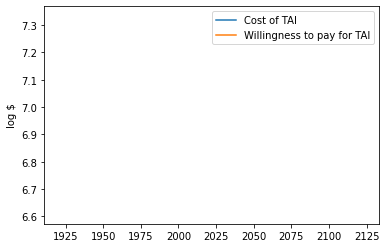

## RUN 19/10000 ##
Diagnostic: tai_flop_size=31.910754595796508, nonscaling_delay=5.174460716404906, algo_doubling_rate=3.2497307055147844, possible_algo_reduction=1.9416721450728522, initial_flops_per_dollar=1.3202248991387723e+17, flops_halving_rate=2.837442510315119, max_flops_per_dollar=6.418284855136417e+26, initial_pay=55122242.352973655, gdp_growth=1.0194619579740918, max_gdp_frac=0.0036587740262141425, willingness_ramp=0.9306801325938795, spend_doubling_time=1.2200800934372626
-
It takes 31.9 log FLOPs (10 nonillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 26.8 log FLOPs (100 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 1.2x per year to a max of 0.0037% of GDP. GDP grows at a rate of 1.019x per year.
If we are 93.0% of the way to paying for TAI, we will 

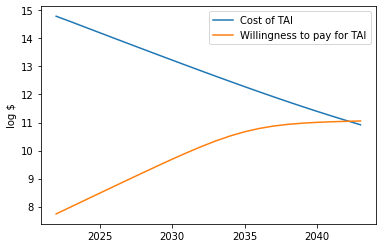

## RUN 20/10000 ##
Diagnostic: tai_flop_size=39.11409754873793, nonscaling_delay=1.9287009551370593, algo_doubling_rate=4.52320348980494, possible_algo_reduction=4.4710616650225425, initial_flops_per_dollar=1.0984352980676658e+17, flops_halving_rate=2.5670508680454915, max_flops_per_dollar=1.4975818042851028e+25, initial_pay=29454620.394874454, gdp_growth=1.0193208605936983, max_gdp_frac=0.02128844180582693, willingness_ramp=0.8546334674464028, spend_doubling_time=0.8829414009546033
-
It takes 39.1 log FLOPs (one million decillion) for transformative capabilities.
Every 4.5 years algorithms get 2x better, with 4.5 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.9x per year to a max of 0.0213% of GDP. GDP grows at a rate of 1.019x per year.
If we are 85.0% of the way to paying for TAI, we

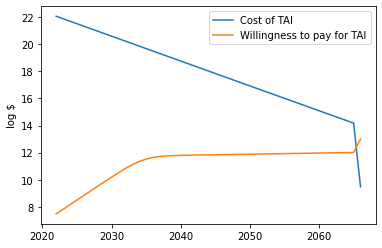

## RUN 21/10000 ##
Diagnostic: tai_flop_size=26.680614059535113, nonscaling_delay=11.539319450787403, algo_doubling_rate=1.669599659588975, possible_algo_reduction=2.453030320096148, initial_flops_per_dollar=1.3631993113095187e+17, flops_halving_rate=2.1912102781072864, max_flops_per_dollar=4.688141270386873e+23, initial_pay=70563126.26439334, gdp_growth=1.020357039094328, max_gdp_frac=0.002242657105237725, willingness_ramp=0.897295783084099, spend_doubling_time=1.200531114165876
-
It takes 26.7 log FLOPs (100 septillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.2 years they get 2x cheaper, to a maximum of 23.7 log FLOPs (100 sextillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.2x per year to a max of 0.0022% of GDP. GDP grows at a rate of 1.02x per year.
If we are 90.0% of the way to paying for TAI, we will ramp

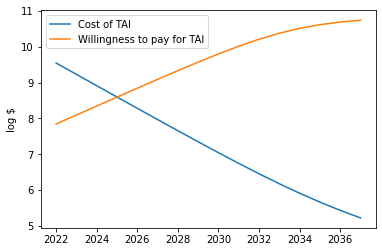

## RUN 22/10000 ##
Diagnostic: tai_flop_size=35.35370571480654, nonscaling_delay=2.971020807774104, algo_doubling_rate=2.6028548122968713, possible_algo_reduction=3.2438721873142686, initial_flops_per_dollar=1.847024276245153e+17, flops_halving_rate=2.788617837461413, max_flops_per_dollar=7.71207648846398e+23, initial_pay=29172175.07377719, gdp_growth=1.0306405280770892, max_gdp_frac=0.005996278320150777, willingness_ramp=0.8641920001973149, spend_doubling_time=0.7869814063612256
-
It takes 35.4 log FLOPs (100 decillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 23.9 log FLOPs (100 sextillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.8x per year to a max of 0.006% of GDP. GDP grows at a rate of 1.031x per year.
If we are 86.0% of the way to paying for TAI, we will ramp 

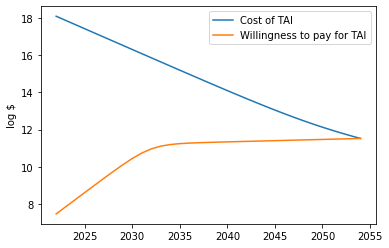

## RUN 23/10000 ##
Diagnostic: tai_flop_size=29.409572000700454, nonscaling_delay=3.8077709215504036, algo_doubling_rate=1.7652379236777826, possible_algo_reduction=2.1341175775330696, initial_flops_per_dollar=1.775168885882037e+17, flops_halving_rate=4.250153565871879, max_flops_per_dollar=1.7521486325665503e+23, initial_pay=17626986.11026494, gdp_growth=1.027142756472445, max_gdp_frac=0.005357494611393622, willingness_ramp=0.797520634041617, spend_doubling_time=1.110478141545946
-
It takes 29.4 log FLOPs (100 octillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 4.3 years they get 2x cheaper, to a maximum of 23.2 log FLOPs (100 sextillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 1.1x per year to a max of 0.0054% of GDP. GDP grows at a rate of 1.027x per year.
If we are 80.0% of the way to paying for TAI, we will ram

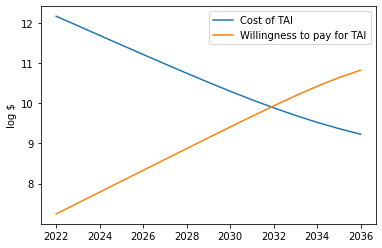

## RUN 24/10000 ##
Diagnostic: tai_flop_size=43.28266483647192, nonscaling_delay=5.687045972144516, algo_doubling_rate=2.254305816492694, possible_algo_reduction=5.403935993922412, initial_flops_per_dollar=1.6390535702278733e+17, flops_halving_rate=3.154881900989838, max_flops_per_dollar=8.094352462766947e+24, initial_pay=84172807.4004647, gdp_growth=1.0207562097746354, max_gdp_frac=0.006903526123397357, willingness_ramp=0.6872387753974202, spend_doubling_time=0.8545908810646342
-
It takes 43.3 log FLOPs (10 billion decillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 5.4 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 24.9 log FLOPs (one septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 0.9x per year to a max of 0.0069% of GDP. GDP grows at a rate of 1.021x per year.
If we are 69.0% of the way to paying for TAI, we wil

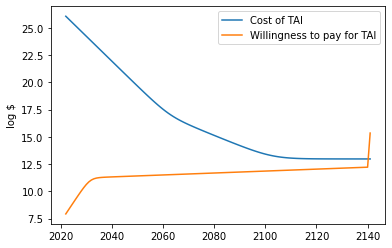

## RUN 25/10000 ##
Diagnostic: tai_flop_size=28.786081513109465, nonscaling_delay=2.943931668322345, algo_doubling_rate=3.5539269433260547, possible_algo_reduction=2.4586471205753924, initial_flops_per_dollar=1.4507131849915955e+17, flops_halving_rate=2.3954252128966096, max_flops_per_dollar=7.897654383271361e+22, initial_pay=15690197.370943828, gdp_growth=1.018699933557222, max_gdp_frac=0.007734007392606059, willingness_ramp=0.8611864674939097, spend_doubling_time=1.6468932567916958
-
It takes 28.8 log FLOPs (10 octillion) for transformative capabilities.
Every 3.6 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.4 years they get 2x cheaper, to a maximum of 22.9 log FLOPs (10 sextillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 1.6x per year to a max of 0.0077% of GDP. GDP grows at a rate of 1.019x per year.
If we are 86.0% of the way to paying for TAI, we will ra

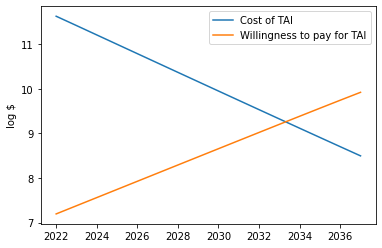

## RUN 26/10000 ##
Diagnostic: tai_flop_size=36.4783115103862, nonscaling_delay=0.8113094881902052, algo_doubling_rate=2.6840705440992076, possible_algo_reduction=3.893713442832407, initial_flops_per_dollar=1.579925984268686e+17, flops_halving_rate=3.1691255801146916, max_flops_per_dollar=3.547712883274036e+23, initial_pay=37158850.852226496, gdp_growth=1.0127053602000184, max_gdp_frac=0.0038613600367042875, willingness_ramp=0.6952170677912438, spend_doubling_time=0.922011737290989
-
It takes 36.5 log FLOPs (one thousand decillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 3.9 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 23.5 log FLOPs (100 sextillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.9x per year to a max of 0.0039% of GDP. GDP grows at a rate of 1.013x per year.
If we are 70.0% of the way to paying for TAI, w

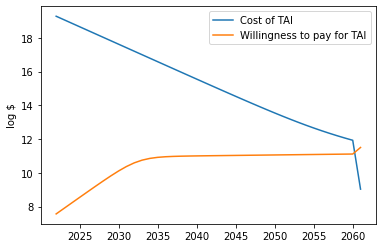

## RUN 27/10000 ##
Diagnostic: tai_flop_size=29.167574674772855, nonscaling_delay=2.993322973783991, algo_doubling_rate=2.6782948284297015, possible_algo_reduction=1.4520651293992326, initial_flops_per_dollar=2.2203477052071638e+17, flops_halving_rate=3.8862026531669702, max_flops_per_dollar=5.213188996669586e+24, initial_pay=10812379.795392087, gdp_growth=1.0227124155376135, max_gdp_frac=0.0019872786707776095, willingness_ramp=0.9744555107816039, spend_doubling_time=0.6762891521734469
-
It takes 29.2 log FLOPs (100 octillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 1.5 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.9 years they get 2x cheaper, to a maximum of 24.7 log FLOPs (one septillion) per $.
We are willing to pay 7.0 log $ (10 million) and this increases by 0.7x per year to a max of 0.002% of GDP. GDP grows at a rate of 1.023x per year.
If we are 97.0% of the way to paying for TAI, we will

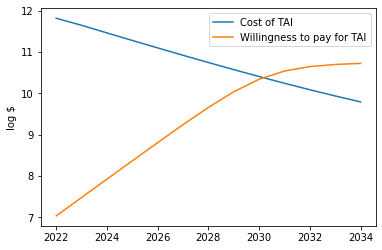

## RUN 28/10000 ##
Diagnostic: tai_flop_size=30.43485057662775, nonscaling_delay=3.2038174824728793, algo_doubling_rate=3.9564924980572598, possible_algo_reduction=2.0240730276043584, initial_flops_per_dollar=2.297377568776787e+17, flops_halving_rate=2.9119323371932078, max_flops_per_dollar=4.492141323022422e+25, initial_pay=23105604.422460306, gdp_growth=1.0235948193607372, max_gdp_frac=0.004511851717518676, willingness_ramp=0.8341751230134639, spend_doubling_time=1.1637707940234108
-
It takes 30.4 log FLOPs (one nonillion) for transformative capabilities.
Every 4.0 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 25.7 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.2x per year to a max of 0.0045% of GDP. GDP grows at a rate of 1.024x per year.
If we are 83.0% of the way to paying for TAI, we will r

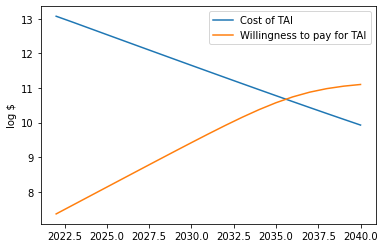

## RUN 29/10000 ##
Diagnostic: tai_flop_size=45.389897242009056, nonscaling_delay=2.519800975189002, algo_doubling_rate=1.2452502850702096, possible_algo_reduction=5.264792349846971, initial_flops_per_dollar=1.4708660947396854e+17, flops_halving_rate=3.6007559319438776, max_flops_per_dollar=1.615165650019428e+23, initial_pay=14792696.603098901, gdp_growth=1.0182355019465534, max_gdp_frac=0.00900567810599246, willingness_ramp=0.7441182370405572, spend_doubling_time=2.4683768705871425
-
It takes 45.4 log FLOPs (one trillion decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 5.3 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 23.2 log FLOPs (100 sextillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 2.5x per year to a max of 0.009% of GDP. GDP grows at a rate of 1.018x per year.
If we are 74.0% of the way to paying for TAI, w

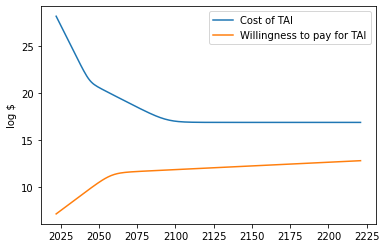

## RUN 30/10000 ##
Diagnostic: tai_flop_size=34.89247132111494, nonscaling_delay=4.938927391059887, algo_doubling_rate=3.1950548670788645, possible_algo_reduction=2.861248089193738, initial_flops_per_dollar=1.4350799576016893e+17, flops_halving_rate=2.8307462361624114, max_flops_per_dollar=2.2973104088513138e+23, initial_pay=7455619.953663691, gdp_growth=1.0259949622546556, max_gdp_frac=0.01042579193588262, willingness_ramp=0.7185140672166276, spend_doubling_time=1.2437382049628427
-
It takes 34.9 log FLOPs (10 decillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 23.4 log FLOPs (100 sextillion) per $.
We are willing to pay 6.9 log $ (one million) and this increases by 1.2x per year to a max of 0.0104% of GDP. GDP grows at a rate of 1.026x per year.
If we are 72.0% of the way to paying for TAI, we will ra

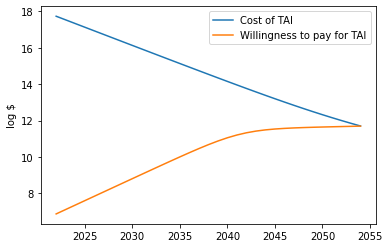

## RUN 101/10000 ##
## RUN 201/10000 ##
## RUN 301/10000 ##
## RUN 401/10000 ##
## RUN 501/10000 ##
## RUN 601/10000 ##
## RUN 701/10000 ##
## RUN 801/10000 ##
## RUN 901/10000 ##
## RUN 1001/10000 ##
## RUN 1101/10000 ##
## RUN 1201/10000 ##
## RUN 1301/10000 ##
## RUN 1401/10000 ##
## RUN 1501/10000 ##
## RUN 1601/10000 ##
## RUN 1701/10000 ##
## RUN 1801/10000 ##
## RUN 1901/10000 ##
## RUN 2001/10000 ##
## RUN 2101/10000 ##
## RUN 2201/10000 ##
## RUN 2301/10000 ##
## RUN 2401/10000 ##
## RUN 2501/10000 ##
## RUN 2601/10000 ##
## RUN 2701/10000 ##
## RUN 2801/10000 ##
## RUN 2901/10000 ##
## RUN 3001/10000 ##
## RUN 3101/10000 ##
## RUN 3201/10000 ##
## RUN 3301/10000 ##
## RUN 3401/10000 ##
## RUN 3501/10000 ##
## RUN 3601/10000 ##
## RUN 3701/10000 ##
## RUN 3801/10000 ##
## RUN 3901/10000 ##
## RUN 4001/10000 ##
## RUN 4101/10000 ##
## RUN 4201/10000 ##
## RUN 4301/10000 ##
## RUN 4401/10000 ##
## RUN 4501/10000 ##
## RUN 4601/10000 ##
## RUN 4701/10000 ##
## RUN 4801/10000 ##
#

In [38]:
tai_years = []
tai_flop_size_log_ = []
plt.ioff()
print('Running')

for r in range(RUNS):
    print_diagnostic = r < 30
    if print_diagnostic or r % 100 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    tai_flop_size_ = sample(tai_flop_size, credibility=CREDIBLE_INTERVAL)  # TODO: DRY out `, credibility=CREDIBLE_INTERVAL`
    tai_flop_size_log_.append(tai_flop_size_)
    algo_doubling_rate_ = sample(algo_doubling_rate, credibility=CREDIBLE_INTERVAL)
    possible_algo_reduction_ = possible_algo_reduction_fn(sample(min_reduction, credibility=CREDIBLE_INTERVAL),
                                                          sample(max_reduction, credibility=CREDIBLE_INTERVAL),
                                                          tai_flop_size_)
    initial_flops_per_dollar_ = 10 ** sample(initial_flops_per_dollar, credibility=CREDIBLE_INTERVAL)
    flops_halving_rate_ = sample(flops_halving_rate, credibility=CREDIBLE_INTERVAL)
    max_flops_per_dollar_ = 10 ** sample(max_flops_per_dollar, credibility=CREDIBLE_INTERVAL)
    initial_pay_ = 10 ** sample(initial_pay, credibility=CREDIBLE_INTERVAL)
    gdp_growth_ = sample(gdp_growth, credibility=CREDIBLE_INTERVAL)
    max_gdp_frac_ = sample(max_gdp_frac, credibility=CREDIBLE_INTERVAL)
    willingness_ramp_ = sample(willingness_ramp, credibility=CREDIBLE_INTERVAL)
    spend_doubling_time_ = sample(spend_doubling_time, credibility=CREDIBLE_INTERVAL)
    nonscaling_delay_ = sample(nonscaling_delay, credibility=CREDIBLE_INTERVAL)
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    
    if print_diagnostic:
        diagnostic = 'Diagnostic: tai_flop_size={}, nonscaling_delay={}, algo_doubling_rate={}, '
        diagnostic += 'possible_algo_reduction={}, initial_flops_per_dollar={}, flops_halving_rate={}, '
        diagnostic += 'max_flops_per_dollar={}, initial_pay={}, gdp_growth={}, max_gdp_frac={}, '
        diagnostic += 'willingness_ramp={}, spend_doubling_time={}'
        print(diagnostic.format(tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
                                possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
                                max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
                                willingness_ramp_, spend_doubling_time_))
        # TODO: add other recursive variables
        print('-')

        print('It takes {} log FLOPs ({}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                   numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs ({}) per $. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs ({}) per $.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                              numerize(math.log10(initial_flops_per_dollar_)),
                                                                              np.round(flops_halving_rate_, 1),
                                                                              np.round(math.log10(max_flops_per_dollar_), 1),
                                                                              numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log $ ({}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        print('If we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    recursive = False
    for y in years:
        if not tai_created:  
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                
            cost_of_tai_ = flops_needed_ / flops_per_dollar_
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            p_recursive = p_rapid_recursive_self_improvement(flops_needed_,
                                                             total_compute_,
                                                             base_p_recursive,
                                                             recursive_curve_steepness,
                                                             recursive_curve_inflection)
            p_recursive = p_recursive / 8 # Attempt to turn CDF into PDF (approximation)
            
            cost_of_tai_collector.append(cost_of_tai_)
            willingness_collector.append(willingness_)
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ * willingness_ramp_ <= willingness_:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                             final_chance_of_nonscaling_issue,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            
            r_ = random.random()
            if not tai_created and not is_nonscaling_issue and not recursive and r_ < p_recursive:
                flops_halving_rate__ = sample(recursive_flops_halving_rate, credibility=CREDIBLE_INTERVAL)
                flops_halving_rate_ = flops_halving_rate__ if flops_halving_rate__ < flops_halving_rate_ else flops_halving_rate_
                algo_doubling_rate__ = sample(recursive_algo_doubling_rate, credibility=CREDIBLE_INTERVAL)
                algo_doubling_rate_ = algo_doubling_rate__ if algo_doubling_rate__ < algo_doubling_rate_ else algo_doubling_rate_
                spend_doubling_time__ = sample(recursive_spend_doubling_time, credibility=CREDIBLE_INTERVAL)
                spend_doubling_time_ = spend_doubling_time__ if spend_doubling_time__ < spend_doubling_time_ else spend_doubling_time_
                gdp_growth__ = sample(recursive_gdp_growth, credibility=CREDIBLE_INTERVAL)
                gdp_growth_ = gdp_growth__ if gdp_growth__ > gdp_growth_ else gdp_growth_
                initial_chance_of_nonscaling_issue_ = recursive_initial_chance_of_nonscaling_issue
                final_chance_of_nonscaling_issue_ = recursive_final_chance_of_nonscaling_issue
                recursive = True
                # TODO: fix issue where this changes the variables as of 2022 rather than as of the time of the rapid recursion

                if print_diagnostic:
                    print(('--- rapid recursive loop (p={}, r_={}) - set flops_having_rate={}, algo_doubling_rate={} ' +
                           'spend_doubling_time={}, gdp_growth={}, initial_chance_of_nonscaling_issue={} ' +
                           'final_chance_of_nonscaling_issue={}').format(p_recursive,
                                                                         r_,
                                                                         flops_halving_rate_,
                                                                         algo_doubling_rate_,
                                                                         spend_doubling_time_,
                                                                         gdp_growth_,
                                                                         initial_chance_of_nonscaling_issue,
                                                                         final_chance_of_nonscaling_issue))
                if event_occurs(p_recursive_creates_tai_instantly):
                    if print_diagnostic:
                        print('--- /!\ RRSI LOOP CREATES TAI in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                        
            elif not tai_created and not is_nonscaling_issue and not recursive and print_diagnostic:
                print('--- no rapid recursive loop (p={}, r_={})'.format(p_recursive, r_))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        tai_years.append(MAX_YEAR + 1)


In [39]:
out = get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Jul 21 11:28PM CT):
#['5%: 2028',
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2049',
# '50%: 2056',
# '60%: 2064',
# '70%: 2075',
# '80%: 2091',
# '90%: 2159',
# '95%: >2222']


['5%: 2028',
 '10%: 2031',
 '20%: 2036',
 '30%: 2042',
 '40%: 2049',
 '50%: 2056',
 '60%: 2064',
 '70%: 2076',
 '80%: 2097',
 '90%: 2209',
 '95%: >2222']

In [40]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['5%: 6 years from now',
 '10%: 9 years from now',
 '20%: 14 years from now',
 '30%: 20 years from now',
 '40%: 27 years from now',
 '50%: 34 years from now',
 '60%: 42 years from now',
 '70%: 54 years from now',
 '80%: 75 years from now',
 '90%: 187 years from now',
 '95%: >200 years from now']

In [41]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <2 years')
print_chance_tai_by_year(tai_years, 2023)


## Within <2 years


'0% chance of TAI by EOY 2023'

In [42]:
print_chance_tai_by_year(tai_years, 2024)

'1% chance of TAI by EOY 2024'

In [43]:
print_chance_tai_by_year(tai_years, 2025)

'2% chance of TAI by EOY 2025'

In [44]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'4% chance of TAI by EOY 2027'

In [45]:
print_chance_tai_by_year(tai_years, 2029)

'7% chance of TAI by EOY 2029'

In [46]:
print_chance_tai_by_year(tai_years, 2030)

'9% chance of TAI by EOY 2030'

In [47]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'12% chance of TAI by EOY 2032'

In [48]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'20% chance of TAI by EOY 2036'

In [49]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'22% chance of TAI by EOY 2037'

In [50]:
print_chance_tai_by_year(tai_years, 2039)

'25% chance of TAI by EOY 2039'

In [51]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'30% chance of TAI by EOY 2042'

In [52]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'38% chance of TAI by EOY 2047'

In [53]:
print_chance_tai_by_year(tai_years, 2049)

'41% chance of TAI by EOY 2049'

In [54]:
print_chance_tai_by_year(tai_years, 2059)

'55% chance of TAI by EOY 2059'

In [55]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'56% chance of TAI by EOY 2060'

In [56]:
print_chance_tai_by_year(tai_years, 2069)

'65% chance of TAI by EOY 2069'

In [57]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'65% chance of TAI by EOY 2070'

In [58]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'67% chance of TAI by EOY 2072'

In [59]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'72% chance of TAI by EOY 2078'

In [60]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'80% chance of TAI by EOY 2097'

In [61]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'81% chance of TAI by EOY 2100'

In [62]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'85% chance of TAI by EOY 2122'

In [63]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'91% chance of TAI by EOY 2222'

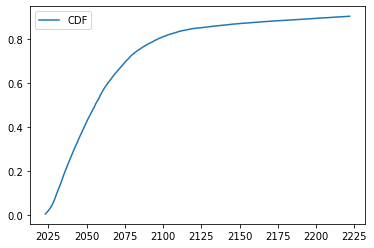

In [64]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

<string>:192: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:193: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

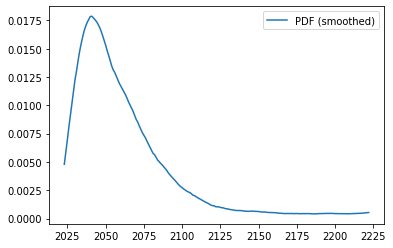

In [65]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [66]:
cdf[:len(bins)]

array([0.0048, 0.0118, 0.0197, 0.0293, 0.0405, 0.0535, 0.0696, 0.0889,
       0.1073, 0.124 , 0.1418, 0.1618, 0.1819, 0.2   , 0.2183, 0.2348,
       0.2515, 0.2684, 0.2856, 0.3019, 0.3167, 0.3318, 0.3489, 0.364 ,
       0.3784, 0.3935, 0.4098, 0.4255, 0.4388, 0.4526, 0.4653, 0.4788,
       0.4904, 0.5073, 0.5188, 0.5308, 0.5458, 0.5584, 0.5708, 0.582 ,
       0.5916, 0.6023, 0.6103, 0.62  , 0.6297, 0.6387, 0.6469, 0.6549,
       0.6628, 0.6706, 0.6786, 0.687 , 0.6946, 0.7031, 0.7096, 0.7172,
       0.7248, 0.731 , 0.7354, 0.7421, 0.7474, 0.7521, 0.7569, 0.7616,
       0.766 , 0.7699, 0.7737, 0.7785, 0.782 , 0.7851, 0.7884, 0.7925,
       0.7967, 0.7991, 0.8035, 0.806 , 0.8091, 0.8122, 0.8143, 0.8172,
       0.8201, 0.8224, 0.8246, 0.8266, 0.8286, 0.8305, 0.8325, 0.8352,
       0.8373, 0.8385, 0.8403, 0.8411, 0.8429, 0.8443, 0.8458, 0.8476,
       0.8486, 0.8492, 0.8503, 0.8512, 0.8525, 0.8531, 0.8536, 0.8548,
       0.856 , 0.8565, 0.857 , 0.8581, 0.8589, 0.8601, 0.8607, 0.8617,
      

In [67]:
pdf[:len(bins)]

array([0.0048, 0.007 , 0.0079, 0.0096, 0.0112, 0.013 , 0.0161, 0.0193,
       0.0184, 0.0167, 0.0178, 0.02  , 0.0201, 0.0181, 0.0183, 0.0165,
       0.0167, 0.0169, 0.0172, 0.0163, 0.0148, 0.0151, 0.0171, 0.0151,
       0.0144, 0.0151, 0.0163, 0.0157, 0.0133, 0.0138, 0.0127, 0.0135,
       0.0116, 0.0169, 0.0115, 0.012 , 0.015 , 0.0126, 0.0124, 0.0112,
       0.0096, 0.0107, 0.008 , 0.0097, 0.0097, 0.009 , 0.0082, 0.008 ,
       0.0079, 0.0078, 0.008 , 0.0084, 0.0076, 0.0085, 0.0065, 0.0076,
       0.0076, 0.0062, 0.0044, 0.0067, 0.0053, 0.0047, 0.0048, 0.0047,
       0.0044, 0.0039, 0.0038, 0.0048, 0.0035, 0.0031, 0.0033, 0.0041,
       0.0042, 0.0024, 0.0044, 0.0025, 0.0031, 0.0031, 0.0021, 0.0029,
       0.0029, 0.0023, 0.0022, 0.002 , 0.002 , 0.0019, 0.002 , 0.0027,
       0.0021, 0.0012, 0.0018, 0.0008, 0.0018, 0.0014, 0.0015, 0.0018,
       0.001 , 0.0006, 0.0011, 0.0009, 0.0013, 0.0006, 0.0005, 0.0012,
       0.0012, 0.0005, 0.0005, 0.0011, 0.0008, 0.0012, 0.0006, 0.001 ,
      

<string>:192: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:193: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

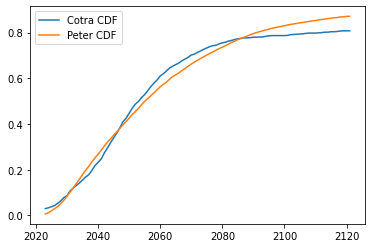

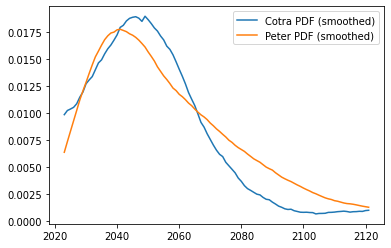

In [68]:
ajeya_cdf = [0.03 , 0.033, 0.038, 0.043, 0.053, 0.064, 0.078, 0.086, 0.107, 0.12 , 0.131, 0.142, 0.155, 0.168, 0.178,
             0.197, 0.218, 0.232, 0.247, 0.273, 0.295, 0.318, 0.339, 0.36 , 0.383, 0.41 , 0.425, 0.447, 0.469, 0.487,
             0.499, 0.516, 0.529, 0.546, 0.564, 0.579, 0.593, 0.61 , 0.62 , 0.632, 0.645, 0.653, 0.66 , 0.667, 0.677,
             0.684, 0.692, 0.702, 0.706, 0.713, 0.72 , 0.727, 0.733, 0.739, 0.743, 0.745, 0.751, 0.755, 0.758, 0.763,
             0.766, 0.77 , 0.773, 0.775, 0.777, 0.777, 0.778, 0.78 , 0.78 , 0.781, 0.781, 0.784, 0.786, 0.787, 0.787,
             0.787, 0.787, 0.787, 0.788, 0.791, 0.792, 0.793, 0.794, 0.795, 0.797, 0.798, 0.798, 0.798, 0.799, 0.8  ,
             0.802, 0.802, 0.804, 0.804, 0.805, 0.807, 0.808, 0.808, 0.808]
ajeya_pdf = np.append(np.array(ajeya_cdf[0]), np.diff(ajeya_cdf[:len(bins)]))
ajeya_pdf_smoothed = savitzky_golay(ajeya_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0065, 0.0114, 0.0202, 0.0297, 0.0387, 0.0523, 0.0667, 0.0845,
       0.1022, 0.119 , 0.1403, 0.1584, 0.179 , 0.1977, 0.2148, 0.2347,
       0.251 , 0.2677, 0.285 , 0.3037, 0.3203, 0.3343, 0.351 , 0.365 ,
       0.3814, 0.3959, 0.4112, 0.4251, 0.4413, 0.4543, 0.469 , 0.4848,
       0.4993, 0.5118, 0.524 , 0.5363, 0.5497, 0.5629, 0.5734, 0.5835,
       0.5959, 0.6075, 0.6154, 0.6239, 0.6335, 0.6431, 0.6529, 0.6623,
       0.6707, 0.6789, 0.6869, 0.6944, 0.7018, 0.7091, 0.7158, 0.7236,
       0.7302, 0.7365, 0.7426, 0.7496, 0.757 , 0.7627, 0.7693, 0.7744,
       0.7798, 0.7851, 0.7908, 0.7959, 0.8002, 0.8042, 0.808 , 0.8117,
       0.8152, 0.8191, 0.8216, 0.8248, 0.8272, 0.83  , 0.8333, 0.836 ,
       0.8381, 0.8403, 0.8428, 0.8447, 0.8473, 0.849 , 0.8513, 0.8531,
       0.8552, 0.8574, 0.8593, 0.8615, 0.863 , 0.8649, 0.866 , 0.8685,
       0.8696, 0.8709, 0.8717, 0.8729, 0.8742, 0.875 , 0.8762, 0.877 ,
       0.8776, 0.8785, 0.8795, 0.8805, 0.8812, 0.8818, 0.8826, 0.8835,
       0.8847, 0.8853, 0.8858, 0.8869, 0.8874, 0.8876, 0.8882, 0.8888,
       0.8896, 0.8904, 0.891 , 0.8916, 0.8922, 0.8925, 0.8932, 0.8938,
       0.8943, 0.895 , 0.8959, 0.8967, 0.8974, 0.898 , 0.899 , 0.8996,
       0.9   , 0.9004, 0.9006, 0.9011, 0.9015, 0.9023, 0.9029, 0.9032,
       0.9039, 0.9041, 0.9045, 0.9048, 0.9052, 0.9057, 0.9061, 0.9064,
       0.9067, 0.907 , 0.9073, 0.9076, 0.908 , 0.9086, 0.9092, 0.91  ,
       0.9102, 0.9106, 0.9107, 0.911 , 0.9114, 0.9117, 0.9123, 0.9128,
       0.913 , 0.9133, 0.9136, 0.914 , 0.9143, 0.9145, 0.9151, 0.9155,
       0.9156, 0.916 , 0.9164, 0.9167, 0.9172, 0.9175, 0.918 , 0.9183,
       0.9189, 0.9195, 0.92  , 0.9202, 0.9204, 0.9206, 0.9208, 0.9212,
       0.9217, 0.9221, 0.9224, 0.9231, 0.9234, 0.9237, 0.9244]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], ajeya_cdf[:99], label='Cotra CDF')
plt.plot(bins[:99], peter_cdf[:99], label='Peter CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], ajeya_pdf_smoothed[:99], label='Cotra PDF (smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Peter PDF (smoothed)')
plt.legend()
plt.show()